In [1]:
import networkx as nx
import csv
import json
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import seaborn as sns
import community
import pandas as pd

In [11]:
with open('shorter_edgelist.csv', 'rb') as file:
    Big = nx.read_weighted_edgelist(file, delimiter='~')

#### Node attribute (Which awards)

In [12]:
with open('node_attr1.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)
    node_attributes = defaultdict(dict)
    for row in reader:
        if int(row[1]) > 0:
            node_attributes[row[0]]['NIH'] = 1
        else:
            node_attributes[row[0]]['NIH'] = 0
        if int(row[2]) > 0:
            node_attributes[row[0]]['NSF'] = 1
        else:
            node_attributes[row[0]]['NSF'] = 0
        if int(row[3]) > 0:
            node_attributes[row[0]]['USDA'] = 1
        else:
            node_attributes[row[0]]['USDA'] = 0

In [13]:
with open('institution_attr1.csv', 'r') as file:
    reader = csv.reader(file, delimiter = ',')
    next(reader)
    univlist = set()
    for row in reader:
        univlist.add(int(row[1]))
    univ_table = {x:0 for x in univlist}
    
with open('institution_attr1.csv', 'r') as file:
    reader = csv.reader(file, delimiter = ',')
    next(reader)
    node_attributes2 = {}
    for row in reader:
        if row[0] not in node_attributes2:
            node_attributes2[row[0]] = univ_table.copy()
        node_attributes2[row[0]][int(row[1])] = 1

In [14]:
nx.set_node_attributes(Big, node_attributes)
nx.set_node_attributes(Big, node_attributes2)

In [15]:
BigLCC = Big.subgraph(max(nx.connected_components(Big), key=len))

In [5]:
print(nx.info(BigLCC))

Name: 
Type: Graph
Number of nodes: 44774
Number of edges: 1263365
Average degree:  56.4330


In [6]:
print(nx.info(Big))

Name: 
Type: Graph
Number of nodes: 47594
Number of edges: 1271189
Average degree:  53.4180


### Drawing CNM communities

In [2]:
with open('CNMresult.txt', 'r') as textfile:
    cnm_communities = json.loads(textfile.readline())

In [3]:
partition = {}

for x in cnm_communities.keys():
    for node in cnm_communities[x]:
        partition[node] = int(x)

In [4]:
len(cnm_communities.keys())

440

In [5]:
largest_comm = {int(x):y for x,y in cnm_communities.items() if len(y) > 1000}

In [6]:
largest_comm.keys()

dict_keys([0, 1, 5, 6, 7, 8])

In [7]:
community_nodes = set()

for key in largest_comm.keys():
    nodes_cnm = largest_comm[key]
    for node in nodes_cnm:
        community_nodes.add(node)

In [8]:
community_dict = defaultdict(list)
for x in partition.keys():
    community_dict[partition[x]].append(x)

Attributes and Ground Truth

In [16]:
ground_truth = {}

ground_truth['exclusive_nsf'] = list(filter(lambda x: (x[1]['NSF'] >= 1 and x[1]['NIH']==0 and x[1]['USDA']==0), BigLCC.nodes(data=True)))
ground_truth['exclusive_nih'] = list(filter(lambda x: (x[1]['NSF'] ==0 and x[1]['NIH']>= 1 and x[1]['USDA']==0), BigLCC.nodes(data=True)))
ground_truth['exclusive_usda'] = list(filter(lambda x: (x[1]['NSF']==0 and x[1]['NIH']==0 and x[1]['USDA']>= 1), BigLCC.nodes(data=True)))

ground_truth['combo_nsf_nih'] = list(filter(lambda x: (x[1]['NSF']>= 1 and x[1]['NIH']>= 1 and x[1]['USDA']== 0), BigLCC.nodes(data=True)))
ground_truth['combo_nsf_usda'] = list(filter(lambda x: (x[1]['NSF']>= 1 and x[1]['NIH']==0 and x[1]['USDA']>= 1), BigLCC.nodes(data=True)))
ground_truth['combo_nih_usda'] = list(filter(lambda x: (x[1]['NSF']==0 and x[1]['NIH']>= 1 and x[1]['USDA']>= 1), BigLCC.nodes(data=True)))

ground_truth['serve_all'] = list(filter(lambda x: (x[1]['NSF']>= 1 and x[1]['NIH']>= 1 and x[1]['USDA']>= 1), BigLCC.nodes(data=True)))
ground_truth['serve_other'] = list(filter(lambda x: (x[1]['NSF']==0 and x[1]['NIH']==0 and x[1]['USDA']== 0), BigLCC.nodes(data=True)))

ground_truth['serve_nsf'] = list(filter(lambda x: (x[1]['NSF'] >= 1), BigLCC.nodes(data=True)))
ground_truth['serve_nih'] = list(filter(lambda x: (x[1]['NIH']>= 1 ), BigLCC.nodes(data=True)))
ground_truth['serve_usda'] = list(filter(lambda x: (x[1]['USDA']>= 1), BigLCC.nodes(data=True)))

ground_truth['serve_nsf_nih'] = list(filter(lambda x: (x[1]['NSF']>= 1 and x[1]['NIH']>= 1 ), BigLCC.nodes(data=True)))
ground_truth['serve_nsf_usda'] = list(filter(lambda x: (x[1]['NSF']>= 1 and x[1]['USDA']>= 1), BigLCC.nodes(data=True)))
ground_truth['serve_nih_usda'] = list(filter(lambda x: (x[1]['NIH']>= 1 and x[1]['USDA']>= 1), BigLCC.nodes(data=True)))

In [17]:
ground_truth_single_attr = defaultdict(list)
list_of_node_attr = BigLCC.node[list(BigLCC.nodes())[0]].keys()

for attr in list_of_node_attr:
    for node in list(BigLCC.nodes(data=True)):
        if node[1][attr] >= 1:
            ground_truth_single_attr[attr].append(node)

In [18]:
## Compare each partition to ground_truth, to see if any are similar to ground
cnm_max = {}

for truth in ground_truth.keys():
    print('Evaluating {}'.format(truth))
    true_community = set([x[0] for x in ground_truth[truth]])
    len_true = len(true_community)
    maxsame = 0
    
    for x in largest_comm.keys():
        cnm_comm = set(largest_comm[x])
        
        number_same = len(true_community.intersection(cnm_comm))
        if number_same > maxsame:
            maxsame = number_same
            cnm_max[truth] = (x, number_same)
            frac = number_same/len_true
            print('New maximum found: Partition {}, with {} common nodes out of {} ({})'.format(x, number_same, len_true, frac))

Evaluating exclusive_nsf
New maximum found: Partition 0, with 54 common nodes out of 7460 (0.007238605898123324)
New maximum found: Partition 1, with 3207 common nodes out of 7460 (0.4298927613941019)
Evaluating exclusive_nih
New maximum found: Partition 0, with 335 common nodes out of 13132 (0.025510204081632654)
New maximum found: Partition 1, with 1844 common nodes out of 13132 (0.14042034724337496)
New maximum found: Partition 5, with 5387 common nodes out of 13132 (0.4102193116052391)
Evaluating exclusive_usda
New maximum found: Partition 0, with 309 common nodes out of 1728 (0.17881944444444445)
New maximum found: Partition 1, with 502 common nodes out of 1728 (0.29050925925925924)
New maximum found: Partition 6, with 522 common nodes out of 1728 (0.3020833333333333)
Evaluating combo_nsf_nih
New maximum found: Partition 0, with 36 common nodes out of 6309 (0.005706134094151213)
New maximum found: Partition 1, with 1663 common nodes out of 6309 (0.2635916944048185)
New maximum fou

In [19]:
node_attribute_by_cluster = defaultdict(dict)

for x in community_dict.keys():
    subgraph = BigLCC.subgraph(community_dict[x])
    tot_nodes = subgraph.number_of_nodes()
    
    for attr in list_of_node_attr:
        node_attribute_by_cluster[x][attr] = Counter(nx.get_node_attributes(subgraph, attr).values())
        nodes_w_attr = node_attribute_by_cluster[x][attr][1]
        node_attribute_by_cluster[x][attr] = (nodes_w_attr/tot_nodes, nodes_w_attr/len(ground_truth_single_attr[attr]))

In [20]:
cnm_max

{'exclusive_nsf': (1, 3207),
 'exclusive_nih': (5, 5387),
 'exclusive_usda': (6, 522),
 'combo_nsf_nih': (5, 2861),
 'combo_nsf_usda': (1, 292),
 'combo_nih_usda': (5, 287),
 'serve_all': (5, 1528),
 'serve_other': (1, 3337),
 'serve_nsf': (1, 6012),
 'serve_nih': (5, 10063),
 'serve_usda': (5, 1981),
 'serve_nsf_nih': (5, 4389),
 'serve_nsf_usda': (5, 1607),
 'serve_nih_usda': (5, 1815)}

In [21]:
#[0, 1, 5, 6, 7, 8]
node_attribute_by_cluster[5]

{'NIH': (0.8262583134904343, 0.43177722474899166),
 'NSF': (0.43394367353641516, 0.3021208483393357),
 'USDA': (0.16265703259709335, 0.3157475294867708),
 9730: (0.07751046883980622, 0.4328289775332416),
 45700: (0.22998604154692504, 0.6721862251019919),
 22165: (0.11528040068971179, 0.23656276326874473),
 14105: (0.1509976188521225, 0.5974658869395711),
 74915: (0.1385992281796535, 0.7847512784751278),
 10151: (0.04959356268987602, 0.3320505772402419),
 77480: (0.17694391986205765, 0.5425478348439073),
 10161: (0.16610559159208474, 0.35691601976005644),
 20150: (0.18285573528204285, 0.447548231511254),
 12090: (0.1199605878972001, 0.23686770428015563),
 10171: (0.16930782494457672, 0.6325153374233129),
 11584: (0.0390015600624025, 0.26595744680851063),
 27201: (0.09590278347976024, 0.11811103246030943),
 10181: (0.03629197799490927, 0.2134234669241912),
 27591: (0.03908366860990229, 0.5378531073446328),
 87501: (0.1198784793497003, 0.6075738660008323),
 10191: (0.03875523441990311, 0.

In [22]:
bargraph = defaultdict(list)
bargraph2 = defaultdict(list)

for attr in list_of_node_attr:
    for community in largest_comm.keys():
        bargraph[attr].append((community, node_attribute_by_cluster[community][attr][1]))
        bargraph2[attr].append((community, node_attribute_by_cluster[community][attr][0]))
    remainder = 1 - sum([x[1] for x in bargraph[attr]])
    bargraph[attr].append(('Smaller communities', remainder ))

In [23]:
%matplotlib inline
testpd = pd.DataFrame([(*t, k) for k, v in bargraph.items() for t in v], columns = ['Community', 'Total', 'Agency'])

agency = testpd[testpd.Agency.isin(['USDA', 'NSF', 'NIH'])]
univ = testpd[testpd.Agency.isin(['USDA', 'NSF', 'NIH']) == False].rename(columns={'Agency':'University ID'})

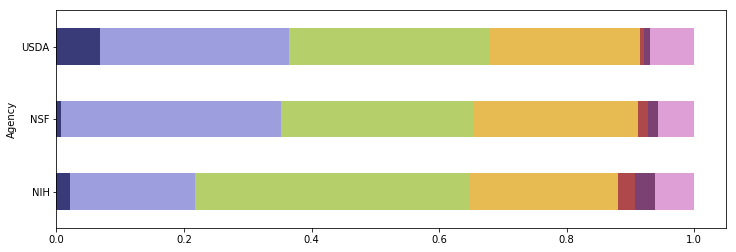

In [36]:
plota = agency.pivot(index = 'Agency', columns='Community').plot.barh(stacked=True, figsize=(12,4), colormap='tab20b', legend=False)
# plt.savefig('Top 10 Community representation in agencies.png')

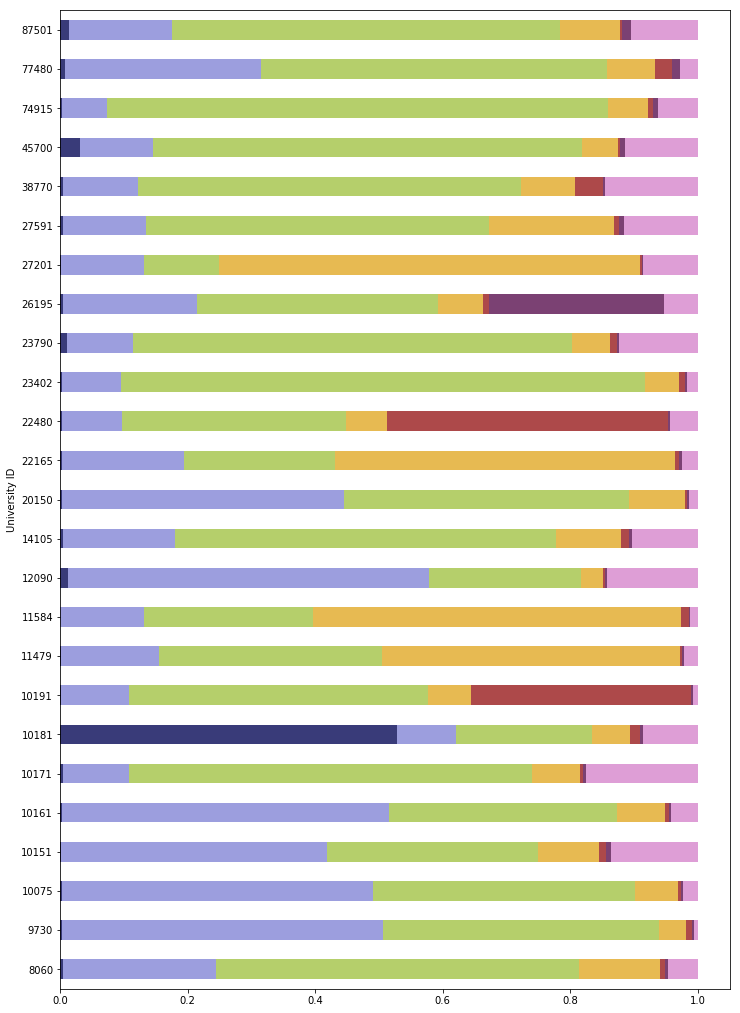

In [25]:
plotb = univ.pivot(index = 'University ID', columns='Community').plot.barh(stacked=True, figsize=(12,18), colormap='tab20b', legend=False)
# plt.savefig('Top 10 Community representation in universities.png')

In [44]:
percomm_pd = pd.DataFrame([(*t,k) for k, v in bargraph2.items() for t in v], columns = ['Community', 'Total', 'Agency'])
lista = percomm_pd[percomm_pd.Community == 5]
listb = lista[lista.Agency.isin(['USDA', 'NSF', 'NIH']) == False].rename(columns={'Agency':'University ID'})
listc = percomm_pd[percomm_pd.Agency.isin(['USDA', 'NSF', 'NIH']) == False].rename(columns={'Agency':'University ID'})

Text(0,0.5,'% of nodes')

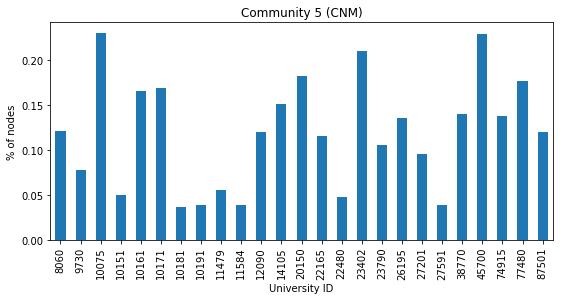

In [45]:
plotc =  listb.pivot(index = 'University ID', columns='Community').plot.bar(legend=False, figsize=(9,4), title='Community 5 (CNM)')
plotc.set_ylabel('% of nodes')

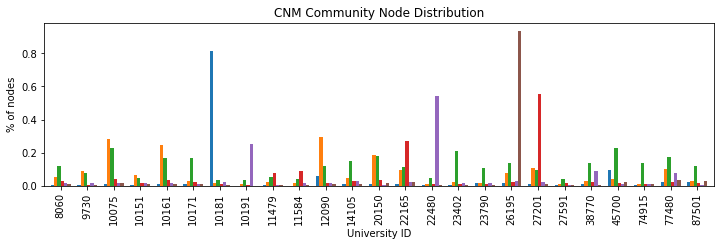

In [50]:
plotc =  listc.pivot(index = 'University ID', columns='Community').plot.bar(width=0.75, legend=False, figsize=(12,3), title='CNM Community Node Distribution')
plotc.set_ylabel('% of nodes')
plt.savefig('CNM community vs univ.png')

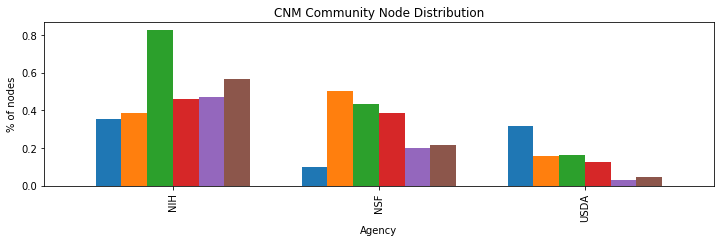

In [48]:
listd = percomm_pd[percomm_pd.Agency.isin(['USDA', 'NSF', 'NIH']) == True]
plotd =  listd.pivot(index = 'Agency', columns='Community').plot.bar(width=0.75, legend=False, figsize=(12,3), title='CNM Community Node Distribution')
plotd.set_ylabel('% of nodes')
plt.savefig('CNM community vs agency.png')

Descriptive Analysis of Communities

In [26]:
desc = {}

for x in largest_comm.keys():
    subg = BigLCC.subgraph(largest_comm[x])
    average_clust = nx.average_clustering(subg)
    
    node = subg.number_of_nodes()
    
    cent = nx.degree(subg)
    maxcent = max([a[1] for a in cent])
    freeman = sum([maxcent-a[1] for a in cent])/((subg.number_of_nodes()-1)*(subg.number_of_nodes()-2))
    
    averagedeg = sum(dict(subg.degree()).values())/node
    
    #Average degree, freeman, average clustering
    desc[x] = (node, averagedeg, freeman, average_clust)

In [27]:
textf = json.dumps(desc)

with open('descriptive_CNM_comm.txt', 'w') as textfile:
    textfile.write(textf)

Graph 1: All communities with >500 nodes

In [ ]:
Copied = BigLCC.copy()
all_nodes = list(Copied.nodes())

for node in all_nodes :
    if node not in community_nodes:
        Copied.remove_node(node)

In [ ]:
colors = zip(largest_comm, sns.color_palette('hls', len(largest_comm)))
colors = dict(colors)

In [ ]:
plt.figure(figsize=(20, 15))
node_size = 20
pos = nx.spring_layout(Copied)

for com in largest_comm.keys():
    list_nodes = largest_comm[com]
    nx.draw_networkx_nodes(Copied, pos, list_nodes, node_size = node_size, node_color = colors[com])
nx.draw_networkx_edges(Copied, pos, alpha=0.5)
plt.axis('off')
plt.savefig('CNM Community Detection.png')

Graph 2: Top 3 communities

In [ ]:
community_nodes2 = set()

for key in list(largest_comm.keys())[0:3]:
    nodes_cnm = largest_comm[key]
    for node in nodes_cnm:
        community_nodes2.add(node)

In [ ]:
Copied2 = BigLCC.copy()
all_nodes = list(Copied2.nodes())

for node in all_nodes :
    if node not in community_nodes2:
        Copied2.remove_node(node)

In [ ]:
colors2 = zip(list(largest_comm.keys())[0:3], sns.color_palette('hls', len(list(largest_comm.keys())[0:3])))
colors2 = dict(colors2)

In [ ]:
colors2

In [ ]:
plt.figure(figsize=(20, 15))
node_size = 20
pos = nx.spring_layout(Copied2)

for com in list(largest_comm.keys())[0:3]:
    list_nodes = largest_comm[com]
    nx.draw_networkx_nodes(Copied2, pos, list_nodes, node_size = node_size, node_color = colors2[com])
nx.draw_networkx_edges(Copied2, pos, alpha=0.5)
plt.axis('off')
plt.savefig('CNM Community Detection - 3 largest communities.png')